In [48]:
#pip install sentence-transformers



In [72]:
import pandas as pd 
import numpy as np
import matplotlib
import pandas as pd
import ast
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [50]:
url = "https://docs.google.com/spreadsheets/d/1HXDOAGqbAYeGKwoPFeLYxepjSO4LDo_k/export?format=xlsx"

df = pd.read_excel(url)

df.head()


,nome,idade,area,emprego,qualidades,defeitos,texto,skills_gemini
0,Lavínia Siqueira,37,Atendimento,Atendente,"Empreendedorismo, Colaboração, Empatia","Apressado, Impulsividade",Atendente por 23 anos,"[\n ""Experiência Comprovada"",\n ""Atendimento..."
1,Srta. Maria Cecília da Mota,59,Jurídico,Advogado,"Criatividade, Empatia, Escuta Ativa","Ansiedade, Ser Crítico Demais",Advogado por 22 anos,"[""Experiência Comprovada"", ""Conhecimento Juríd..."
2,Emilly Siqueira,53,Logística,Gestor de Armazém,"Foco em Resultados, Visão Sistêmica, Trabalho ...","Rigidez, Insegurança",Gestor de Armazém por 5 anos,"[\n ""Liderança Operacional"",\n ""Organização ..."
3,Juan Farias,43,Operações,Supervisor Operacional,"Trabalho Sob Pressão, Pensamento Crítico, Resp...","Falar Demais, Esquecer Detalhes",Supervisor Operacional por 21 anos,"[\n ""Liderança Operacional"",\n ""Ampla Experi..."
4,Olivia Nunes,41,Vendas,Vendedor,"Pensamento Crítico, Ética, Proatividade","Rigidez, Ansiedade",Vendedor por 4 anos,"[""Habilidade de Vendas"", ""Atendimento ao Clien..."


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   nome           92 non-null     object
 1   idade          92 non-null     int64 
 2   area           92 non-null     object
 3   emprego        92 non-null     object
 4   qualidades     92 non-null     object
 5   defeitos       92 non-null     object
 6   texto          92 non-null     object
 7   skills_gemini  92 non-null     object
dtypes: int64(1), object(7)
memory usage: 5.9+ KB


2 Função para limpar textos

In [52]:
def clean_text(t):
    if pd.isna(t):
        return ""
    t = str(t).strip()
    t = re.sub(r"\s+", " ", t)   
    return t



In [53]:
for col in ["nome", "area", "emprego", "qualidades", "defeitos", "texto"]:
    df[col] = df[col].apply(clean_text)

In [54]:
def parse_skills(x):
    if pd.isna(x):
        return []
    try:
        cleaned = x.replace("\n", " ").replace("'", '"')
        return ast.literal_eval(cleaned)
    except:
        return []
    

df["skills_gemini"] = df["skills_gemini"].apply(parse_skills)

4 Transformar qualidades/defeitos em lista

In [55]:
df["qualidades_list"] = df["qualidades"].apply(
    lambda x: [s.strip() for s in x.split(",")] if isinstance(x, str) else []
)

df["defeitos_list"] = df["defeitos"].apply(
    lambda x: [s.strip() for s in x.split(",")] if isinstance(x, str) else []
)

5 Criar coluna completa do perfil (para embeddings)

In [56]:
def build_profile(row):
    parts = [
        row["area"],
        row["emprego"],
        ", ".join(row["qualidades_list"]),
        ", ".join(row["skills_gemini"]) if isinstance(row["skills_gemini"], list) else "",
        row["texto"]
    ]
   
    return " | ".join([p for p in parts if p])

df["perfil_completo"] = df.apply(build_profile, axis=1)

In [57]:
df.head()

,nome,idade,area,emprego,qualidades,defeitos,texto,skills_gemini,qualidades_list,defeitos_list,perfil_completo
0,Lavínia Siqueira,37,Atendimento,Atendente,"Empreendedorismo, Colaboração, Empatia","Apressado, Impulsividade",Atendente por 23 anos,"[Experiência Comprovada, Atendimento ao Client...","[Empreendedorismo, Colaboração, Empatia]","[Apressado, Impulsividade]","Atendimento | Atendente | Empreendedorismo, Co..."
1,Srta. Maria Cecília da Mota,59,Jurídico,Advogado,"Criatividade, Empatia, Escuta Ativa","Ansiedade, Ser Crítico Demais",Advogado por 22 anos,"[Experiência Comprovada, Conhecimento Jurídico...","[Criatividade, Empatia, Escuta Ativa]","[Ansiedade, Ser Crítico Demais]","Jurídico | Advogado | Criatividade, Empatia, E..."
2,Emilly Siqueira,53,Logística,Gestor de Armazém,"Foco em Resultados, Visão Sistêmica, Trabalho ...","Rigidez, Insegurança",Gestor de Armazém por 5 anos,"[Liderança Operacional, Organização e Planejam...","[Foco em Resultados, Visão Sistêmica, Trabalho...","[Rigidez, Insegurança]",Logística | Gestor de Armazém | Foco em Result...
3,Juan Farias,43,Operações,Supervisor Operacional,"Trabalho Sob Pressão, Pensamento Crítico, Resp...","Falar Demais, Esquecer Detalhes",Supervisor Operacional por 21 anos,"[Liderança Operacional, Ampla Experiência Comp...","[Trabalho Sob Pressão, Pensamento Crítico, Res...","[Falar Demais, Esquecer Detalhes]",Operações | Supervisor Operacional | Trabalho ...
4,Olivia Nunes,41,Vendas,Vendedor,"Pensamento Crítico, Ética, Proatividade","Rigidez, Ansiedade",Vendedor por 4 anos,"[Habilidade de Vendas, Atendimento ao Cliente,...","[Pensamento Crítico, Ética, Proatividade]","[Rigidez, Ansiedade]","Vendas | Vendedor | Pensamento Crítico, Ética,..."


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   nome             92 non-null     object
 1   idade            92 non-null     int64 
 2   area             92 non-null     object
 3   emprego          92 non-null     object
 4   qualidades       92 non-null     object
 5   defeitos         92 non-null     object
 6   texto            92 non-null     object
 7   skills_gemini    92 non-null     object
 8   qualidades_list  92 non-null     object
 9   defeitos_list    92 non-null     object
 10  perfil_completo  92 non-null     object
dtypes: int64(1), object(10)
memory usage: 8.0+ KB


In [64]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model.encode(
    df["perfil_completo"].tolist(),
    show_progress_bar=True
)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

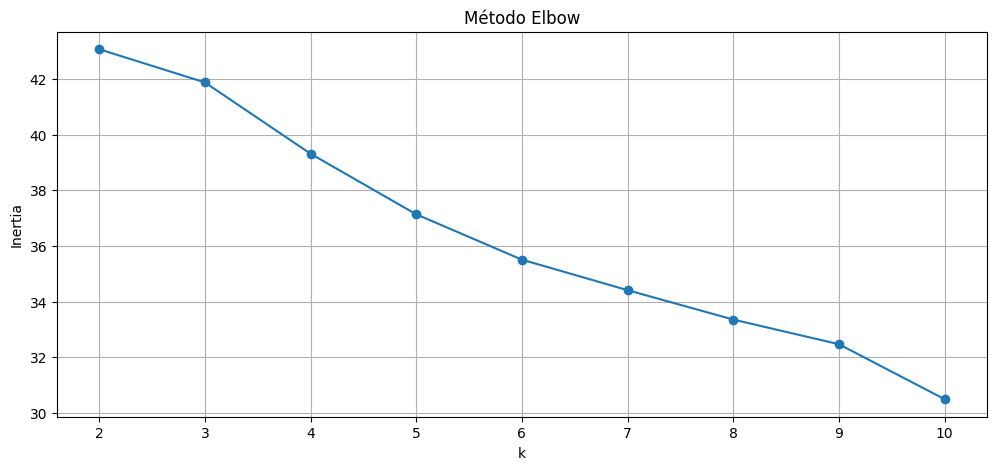

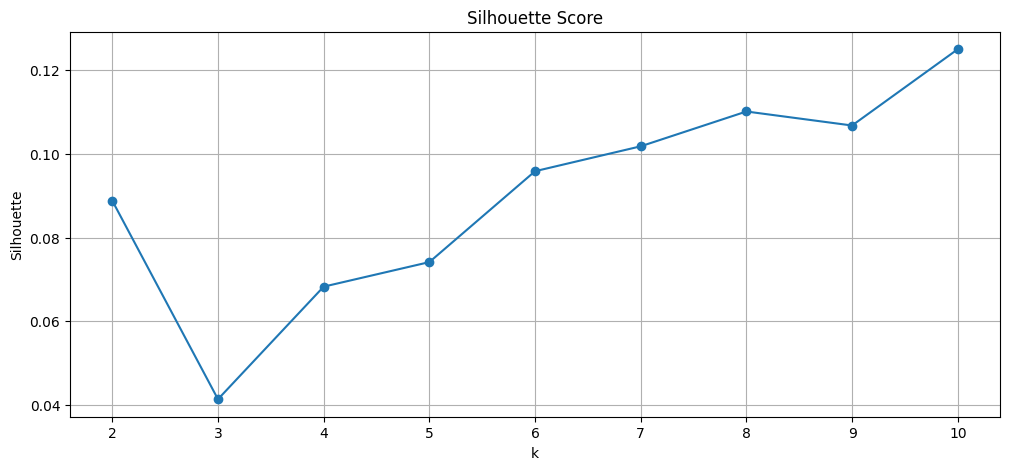

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



inertias = []
silhouettes = []
K_range = range(2, 11)  # analisando entre 2 e 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(embeddings, labels))

# Plot Inertia (Elbow)
plt.figure(figsize=(12,5))
plt.plot(K_range, inertias, marker='o')
plt.title('Método Elbow')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plot Silhouette
plt.figure(figsize=(12,5))
plt.plot(K_range, silhouettes, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()


In [66]:
k = 5  # ajuste depois

kmeans_final = KMeans(n_clusters=k, random_state=42) 

df["cluster"] = kmeans_final.fit_predict(embeddings)




In [67]:
df['cluster'].value_counts()


,count
cluster,
4,39
0,17
1,17
2,12
3,7


In [68]:
for c in sorted(df['cluster'].unique()):
    group = df[df['cluster'] == c]
    print(f"\n=== CLUSTER {c} ===")
    print("Áreas mais comuns:", group['area'].value_counts().head(3).to_dict())
    print("Empregos mais comuns:", group['emprego'].value_counts().head(3).to_dict())



=== CLUSTER 0 ===
Áreas mais comuns: {'Agronegócio': 4, 'Contabilidade': 3, 'TI Infraestrutura': 3}
Empregos mais comuns: {'Técnico Agrícola': 3, 'Fisioterapeuta': 2, 'Analista de Redes': 2}

=== CLUSTER 1 ===
Áreas mais comuns: {'Marketing': 5, 'Produto': 4, 'RH': 4}
Empregos mais comuns: {'Product Owner': 2, 'Generalista de RH': 2, 'Copywriter': 2}

=== CLUSTER 2 ===
Áreas mais comuns: {'Vendas': 7, 'Atendimento': 5}
Empregos mais comuns: {'Atendente': 4, 'Gerente Comercial': 3, 'Vendedor': 2}

=== CLUSTER 3 ===
Áreas mais comuns: {'Design': 7}
Empregos mais comuns: {'Designer Gráfico': 4, 'Designer UX': 2, 'Designer UI': 1}

=== CLUSTER 4 ===
Áreas mais comuns: {'Consultoria': 6, 'Tecnologia': 6, 'Operações': 5}
Empregos mais comuns: {'Supervisor Operacional': 3, 'Consultor Financeiro': 3, 'Consultor de Negócios': 3}


In [69]:
cluster_names = {
    0: "Cluster Verde / Sustentabilidade",
    1: "Cluster Humano-Cuidador",
    2: "Cluster Criativo-Comunicacional",
    3: "Cluster Técnico-Analítico",
    4: "Cluster Operações & Liderança"
}

df["cluster_nomeado"] = df["cluster"].map(cluster_names)
df.head(20)


,nome,idade,area,emprego,qualidades,defeitos,texto,skills_gemini,qualidades_list,defeitos_list,perfil_completo,cluster,cluster_nomeado
0,Lavínia Siqueira,37,Atendimento,Atendente,"Empreendedorismo, Colaboração, Empatia","Apressado, Impulsividade",Atendente por 23 anos,"[Experiência Comprovada, Atendimento ao Client...","[Empreendedorismo, Colaboração, Empatia]","[Apressado, Impulsividade]","Atendimento | Atendente | Empreendedorismo, Co...",2,Cluster Criativo-Comunicacional
1,Srta. Maria Cecília da Mota,59,Jurídico,Advogado,"Criatividade, Empatia, Escuta Ativa","Ansiedade, Ser Crítico Demais",Advogado por 22 anos,"[Experiência Comprovada, Conhecimento Jurídico...","[Criatividade, Empatia, Escuta Ativa]","[Ansiedade, Ser Crítico Demais]","Jurídico | Advogado | Criatividade, Empatia, E...",4,Cluster Operações & Liderança
2,Emilly Siqueira,53,Logística,Gestor de Armazém,"Foco em Resultados, Visão Sistêmica, Trabalho ...","Rigidez, Insegurança",Gestor de Armazém por 5 anos,"[Liderança Operacional, Organização e Planejam...","[Foco em Resultados, Visão Sistêmica, Trabalho...","[Rigidez, Insegurança]",Logística | Gestor de Armazém | Foco em Result...,1,Cluster Humano-Cuidador
3,Juan Farias,43,Operações,Supervisor Operacional,"Trabalho Sob Pressão, Pensamento Crítico, Resp...","Falar Demais, Esquecer Detalhes",Supervisor Operacional por 21 anos,"[Liderança Operacional, Ampla Experiência Comp...","[Trabalho Sob Pressão, Pensamento Crítico, Res...","[Falar Demais, Esquecer Detalhes]",Operações | Supervisor Operacional | Trabalho ...,4,Cluster Operações & Liderança
4,Olivia Nunes,41,Vendas,Vendedor,"Pensamento Crítico, Ética, Proatividade","Rigidez, Ansiedade",Vendedor por 4 anos,"[Habilidade de Vendas, Atendimento ao Cliente,...","[Pensamento Crítico, Ética, Proatividade]","[Rigidez, Ansiedade]","Vendas | Vendedor | Pensamento Crítico, Ética,...",2,Cluster Criativo-Comunicacional
5,Leandro Abreu,44,Operações,Gestor de Projetos,"Capacidade Analítica, Criatividade, Persistência","Apressado, Falta de Paciência",Gestor de Projetos por 20 anos,"[Experiência Comprovada, Liderança Estratégica...","[Capacidade Analítica, Criatividade, Persistên...","[Apressado, Falta de Paciência]",Operações | Gestor de Projetos | Capacidade An...,1,Cluster Humano-Cuidador
6,Vicente Brito,43,Atendimento,Analista de Suporte,"Inteligência Emocional, Criatividade, Capacida...","Ser Crítico Demais, Apressado",Analista de Suporte por 19 anos,"[Experiência Profunda, Resolução de Problemas,...","[Inteligência Emocional, Criatividade, Capacid...","[Ser Crítico Demais, Apressado]",Atendimento | Analista de Suporte | Inteligênc...,0,Cluster Verde / Sustentabilidade
7,Mariana Pacheco,35,Produto,Product Owner,"Empatia, Tomada de Decisão, Flexibilidade","Ansiedade, Procrastinação",Product Owner por 24 anos,"[Visão de Produto, Priorização Estratégica, Ge...","[Empatia, Tomada de Decisão, Flexibilidade]","[Ansiedade, Procrastinação]","Produto | Product Owner | Empatia, Tomada de D...",1,Cluster Humano-Cuidador
8,Sara Rezende,36,Vendas,Vendedor,"Criatividade, Responsabilidade, Organização","Insegurança, Falar Demais",Vendedor por 22 anos,"[Habilidade em Vendas, Experiência Extensa, Re...","[Criatividade, Responsabilidade, Organização]","[Insegurança, Falar Demais]","Vendas | Vendedor | Criatividade, Responsabili...",2,Cluster Criativo-Comunicacional
9,Ana Vitória da Conceição,58,Design,Designer UX,"Colaboração, Empreendedorismo, Comunicação","Apressado, Autocrítica Excessiva",Designer UX por 19 anos,"[Experiência Sólida, Especialização em UX, Ori...","[Colaboração, Empreendedorismo, Comunicação]","[Apressado, Autocrítica Excessiva]","Design | Designer UX | Colaboração, Empreended...",3,Cluster Técnico-Analítico


In [71]:
df.to_excel("C:\\Users\\eduar\\OneDrive\\Desktop\\GS\\(ATUALIZADA)base_pessoas_com_skills_gemini.xlsx", index=False)